In [1]:
# ssh carnd@ip -L 4567:localhost:4567

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc as misc
import cv2 as cv
%matplotlib inline

# Fix error with TF and Keras
# import tensorflow as tf
# tf.python.control_flow_ops = tf

In [3]:
# df = pd.read_csv('./data/driving_log.csv', 
#                  names=['centre_image', 'left_image', 'right_image', 'steering_angle', 'throttle', 'break', 'speed'])
df = pd.read_csv('./data/driving_log.csv')
print(df.shape)
df.head(2)

(8036, 7)


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.14829
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.87963


In [4]:
# D:\SDCND\beta-simulator-windows\recording\IMG\center_2017_02_14_22_05_18_509.jpg

# df = df.replace(to_replace="D:\\\\SDCND\\\\beta-simulator-windows", value='.', regex=True).replace(to_replace='\\\\', value='/', regex=True)
df = df.replace(to_replace="( )?IMG", value='./data/IMG', regex=True)
df.head(2)

,center,left,right,steering,throttle,brake,speed
0,./data/IMG/center_2016_12_01_13_30_48_287.jpg,./data/IMG/left_2016_12_01_13_30_48_287.jpg,./data/IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.14829
1,./data/IMG/center_2016_12_01_13_30_48_404.jpg,./data/IMG/left_2016_12_01_13_30_48_404.jpg,./data/IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.87963


./data/IMG/center_2016_12_01_13_33_01_043.jpg
(160, 320, 3)


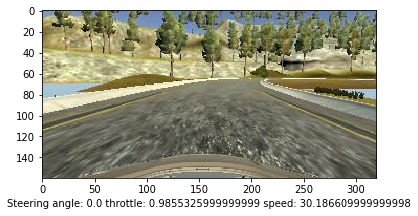

In [5]:
def show_image(index):
    print(df['center'][index])
    image = mpimg.imread(df['center'][index])
    print(image.shape)
    plt.imshow(image)
    plt.xlabel("Steering angle: {} throttle: {} speed: {}".format(df['steering'][index], df['throttle'][index], df['speed'][index]))

show_image(225)

(array([  4.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   2.10000000e+01,   8.00000000e+01,
          1.80000000e+02,   2.14000000e+02,   8.11000000e+02,
          4.95600000e+03,   6.93000000e+02,   7.12000000e+02,
          1.76000000e+02,   1.28000000e+02,   3.80000000e+01,
          6.00000000e+00,   5.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00]),
 array([-0.9426954 , -0.84556063, -0.74842586, -0.65129109, -0.55415632,
        -0.45702155, -0.35988678, -0.26275201, -0.16561724, -0.06848247,
         0.0286523 ,  0.12578707,  0.22292184,  0.32005661,  0.41719138,
         0.51432615,  0.61146092,  0.70859569,  0.80573046,  0.90286523,  1.        ]),
 <a list of 20 Patch objects>)

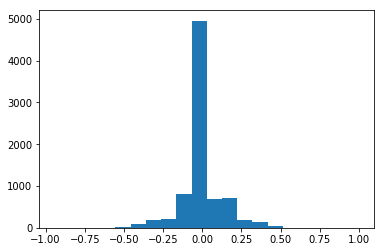

In [6]:
plt.hist(df['steering'], bins=20)

In [7]:
# plt.hist(df['throttle'])

# df2 = df[(df['steering'] != 0)]
df_zero = df[(df['steering'] > -0.01) | (df['steering'] < 0.01)].reset_index(drop=True)
df_zero = df_zero.sample(n=500)

df2 = df[(df['steering'] <= -0.01) | (df['steering'] >= 0.01)].reset_index(drop=True)

print(df2.shape)
print(df2['steering'][100])
df = df2



(3584, 7)
0.1670138


plt.hist(df['steering'], bins=20)

# get images and labels

# camera = center, left, right
def get_images(df, camera='center'):
    result = []
    for path in df[camera]:
        img = mpimg.imread(path)
        img = misc.imresize(img, (64,64))
#         img = cv.resize(img, (64, 64), interpolation=cv.INTER_AREA)
        result.append(img)
    return np.stack(result)

x = get_images(df)
print(x.shape)

y = df.as_matrix(columns=['steering'])
print(y.shape)
print(y[10:15])
plt.hist(y, bins=20)



# use the left and right cameras
steering_adjustment = 0.1
x_left = get_images(df, camera='left')
y_left = y + steering_adjustment

x_right = get_images(df, camera='right')
y_right = y - steering_adjustment

print(x_left.shape)

x = np.append(x, x_left, axis=0)
y = np.append(y, y_left, axis=0)
x = np.append(x, x_right, axis=0)
y = np.append(y, y_right, axis=0)

x_zero = get_images(df_zero)
y_zero = df_zero.as_matrix(columns=['steering'])
x = np.append(x, x_zero, axis=0)
y = np.append(y, y_zero, axis=0)
print(x.shape)
plt.hist(y, bins=60)

In [9]:
# generate more data

# x_flip = [np.fliplr(a) for a in x]
# y_flip = -y

# x = np.append(x, x_flip, axis=0)
# y = np.append(y, y_flip, axis=0)
print(x.shape)
print(y.shape)


(10752, 64, 64, 3)
(10752, 1)


plt.figure(figsize=(20,10))
plt.hist(y, bins=40)

In [2]:
# TODO: Build a model
import keras
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Input, ELU
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

def custom_VGG():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64, 64, 3)))
    model.add(Convolution2D(32, 1, 1, border_mode='same', activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2), border_mode='same'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2), border_mode='same'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2), border_mode='same'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2), border_mode='same'))
    model.add(Dropout(0.25))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2), border_mode='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    adam = Adam(lr=0.00001)
    model.compile(adam, 'mse')
    return model

def Nvidia():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))
    model.add(Convolution2D(24, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(36, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(48, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(ELU())
    model.add(Dense(100))
    model.add(ELU())
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dense(10))
    model.add(ELU())
    model.add(Dense(1))
    adam = Adam(lr=0.0001)
    model.compile(adam, 'mae')
    return model
    


def VGG():
    inp = Input(shape=(64, 64, 3))
    preproc = Lambda(lambda x: (x / 255.0) - 0.5)(inp)
    modelvgg = VGG16(include_top=False, weights=None, input_tensor=preproc, input_shape=None)
    layer = Flatten(name='flatten')(modelvgg.layers[-1].output)
    layer = Dense(2048, activation='elu', name='dense1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(2048, activation='elu', name='dense2')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(512, activation='elu', name='dense2.1')(layer)
    layer = Dense(128, activation='elu', name='dense3')(layer)
    layer = Dense(32, activation='elu', name='dense4')(layer)
    prediction = Dense(2)(layer)
    model = Model(modelvgg.input, prediction)
    adam = Adam(lr=0.00005)
    model.compile(adam, 'mae')
    return model

model = custom_VGG()
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 64, 32)    128         lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 64, 32)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
averagepooling2d_1 (AveragePooli (None, 32, 32, 32)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

history = model.fit(x, y, batch_size=128, nb_epoch=10, validation_split=0.2)

In [15]:
import random

def trans_image(image,steer,translation_range):
    # Translation
    x_translation = translation_range*np.random.uniform()-translation_range/2
    steer_ang = steer + x_translation/translation_range*2*.2
    y_translation = 40*np.random.uniform()-40/2

    translation_matrix = np.float32([[1,0,x_translation],[0,1,y_translation]])
    image_tr = cv.warpAffine(image,translation_matrix,(image.shape[1],image.shape[0]))
    
    return image_tr,steer_ang

def crop_resize(img):
    img = img[50:130,0:320]
    img = cv.cvtColor(img, cv.COLOR_RGB2YUV)
    return cv.resize(img, (64, 64), interpolation=cv.INTER_AREA)

def preprocess_img(row):
    img = None
    steering = None
    camera = ['left', 'center', 'right']
    adjustment_value = 0.1
    steering_adjustment = [adjustment_value, 0, -adjustment_value]
    camera_selection = random.randint(0, 2)
    
    steering = row['steering'] + steering_adjustment[camera_selection]
        
    img = mpimg.imread(row[camera[camera_selection]])
#     img, steering = trans_image(img,steering,100)
    
    img = crop_resize(img)
    
    # randomly adjust brightness 
#     img = cv.cvtColor(img, cv.COLOR_RGB2HSV)
#     brightness = 0.25 + np.random.uniform()
#     img[:, :, 2] = img[:, :, 2] * brightness
#     img = cv.cvtColor(img, cv.COLOR_HSV2RGB)
    
    #random flip
    flip = random.randint(0, 1)
    if flip == 1: 
        img = np.fliplr(img)
        steering = -steering
    
    return img, steering

-0.0670138


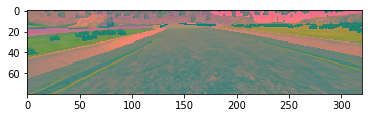

In [16]:
img, steering = preprocess_img(df.iloc[6])
print(steering)
plt.imshow(img)

In [13]:
## instead of above, and just plain training, let's use a generator to help randomly augment data

# df = df[(df['steering'] <= -0.01) | (df['steering'] >= 0.01)].reset_index(drop=True)

import sklearn
import cv2 as cv
def generator(df, batch_size=256):
    
    while 1: # Loop forever so the generator never terminates
        x_sample = []
        y_sample = []
        pr_threshold = 1
        for i in range(batch_size):
            index = np.random.randint(len(df))
            row = df.iloc[index]
            image, steering = preprocess_img(row)
#             keep_pr = 0
#             while keep_pr == 0:
#                 image, steering = preprocess_img(row)
#                 pr_unif = np.random
#                 if abs(steering)<.1:
#                     pr_val = np.random.uniform()
#                     if pr_val>pr_threshold:
#                         keep_pr = 1
#                 else:
#                     keep_pr = 1
#             pr_threshold = 0.99 * pr_threshold
            x_sample.append(image)
            y_sample.append(steering)
        yield np.stack(x_sample), np.asarray(y_sample).reshape(batch_size, 1)
#         pr_threshold = 0.90 * pr_threshold
        
train_generator = generator(df)
validation_generator = generator(df)

## instead of above, and just plain training, let's use a generator to help randomly augment data

import sklearn
import cv2 as cv
def generator(batch_size=256):
    while 1: # Loop forever so the generator never terminates
        x_sample = []
        y_sample = []
        
        for i in range(batch_size):
            index = np.random.randint(len(df))
            row = df.iloc[index]
            image, steering = preprocess_img(row)
            x_sample.append(image)
            y_sample.append(steering)
        yield np.stack(x_sample), np.asarray(y_sample).reshape(batch_size, 1)
        
train_generator = generator(df)
validation_generator = generator(df)

In [14]:
# testing distribution
# test_y = [next(train_generator)[1] for i in range(20)]
# test_y = np.vstack(test_y)

# plt.figure(figsize=(20,10))
# plt.hist(test_y, bins=60)
# this will shuffle a dataframe df.sample(frac=1).reset_index(drop=True)

In [15]:
# history = model.fit_generator(train_generator, samples_per_epoch= 256*20, nb_epoch=10)

history = model.fit(x, y, batch_size=128, nb_epoch=10)

# history = model.fit_generator(train_generator, 
#                               samples_per_epoch= 256*20, 
#                               validation_data=validation_generator, 
#                               nb_val_samples=256*4, 
#                               nb_epoch=20)

Epoch 1/10
10752/10752 [==============================] - 70s - loss: 0.1057      

In [ ]:
### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [17]:
model.save('./model.h5')


In [ ]:
# from keras.models import load_model
# model = load_model('./model.h5')

In [ ]:
import random

# x, y = next(generator(df))


for i in range(1, 10):
    test_index=random.randint(0, len(df))
#     print(test_index)
    test_image = mpimg.imread(df['center'][test_index])
    test_image = crop_resize(test_image)
    y  = df['steering'][test_index]
#     print(y[test_index])
    prediction = model.predict(test_image[None, :, :, :], batch_size=1)
    print("index:", test_index, " actual: ", y, " prediction:", prediction, " diff:", prediction - y)


plt.imshow(test_image)

In [ ]:
# from IPython.display import SVG

# from keras.utils.visualize_util import model_to_dot
# from keras.utils.visualize_util import plot
# plot(model, to_file='./examples/model.png')

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [16]:
result = model.evaluate(x, y, batch_size=128)

print(model.metrics_names)
print(result)

10752/10752 [==============================] - 19s     

In [ ]:
# # TODO: Load test data
# with open('test.p', 'rb') as f:
#     data = pickle.load(f)

# # TODO: Load the feature data to the variable X_train
# X_test = data['features']

# # TODO: Load the label data to the variable y_train
# y_test = data['labels']
    
# # TODO: Preprocess data & one-hot encode the labels
# X_test_normalized = normalize_grayscale(X_test)
# y_test_one_hot = label_binarizer.fit_transform(y_test)

# # TODO: Evaluate model on test data
# result = model.evaluate(X_test_normalized, y_test_one_hot, batch_size=128)

# print(model.metrics_names)
# print(result)

In [ ]:
df['bin'] = round(df['steering']*10, 0)/10

# for i in range(-5, 6):
#     bin = i / 10
#     print(df[df['bin'] == bin]['steering'].count())

def get_sample():
    frames = []
    for i in range(-5, 6):
        bin = i / 10
#         print(df[df['bin'] == bin]['steering'].count())
        size = min(200, len(df[df['bin'] == bin]))
        frame = df[df['bin'] == bin].sample(n=size)
        frames.append(frame)
    return pd.concat(frames)

df_even = get_sample()

df_even.describe()
print(df_even.groupby(df['bin']).count())

plt.hist(df_even['steering'], bins=11)

## instead of above, and just plain training, let's use a generator to help randomly augment data

import sklearn
import cv2 as cv
def generator(batch_size=256):
    
    while 1: # Loop forever so the generator never terminates
        pr_threshold = 1
        x_sample = []
        y_sample = []
        sample = get_sample()
        size = len(sample)
        for i in range(batch_size):
            index = np.random.randint(size)
            row = sample.iloc[index]
            image, steering = preprocess_img(row)
#             keep_pr = 0
#             while keep_pr == 0:
#                 image, steering = preprocess_img(row)
#                 pr_unif = np.random
#                 if abs(steering)<.1:
#                     pr_val = np.random.uniform()
#                     if pr_val>pr_threshold:
#                         keep_pr = 1
#                 else:
#                     keep_pr = 1

            x_sample.append(image)
            y_sample.append(steering)
        yield np.stack(x_sample), np.asarray(y_sample).reshape(batch_size, 1)
        pr_threshold = 0.90 * pr_threshold

def validation_generator(batch_size=256):
    while 1: # Loop forever so the generator never terminates
        x_sample = []
        y_sample = []

        size = len(df)
        for i in range(batch_size):
            index = np.random.randint(size)
            row = df.iloc[index]
            image = mpimg.imread(df['center'][index])
            image = crop_resize(image)
            steering = df['steering'][index]
            
            x_sample.append(image)
            y_sample.append(steering)
        yield np.stack(x_sample), np.asarray(y_sample).reshape(batch_size, 1)
        
train_generator = generator()
validation_generator = validation_generator()